In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-qggjaf6z
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-qggjaf6z
  Resolved https://github.com/tensorflow/docs to commit 979a26f85c60739c37bc3e2808364827cfac3b97
  Preparing metadata (setup.py) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/drive/MyDrive/" 

In [ ]:
import tensorflow as tf
fashion_mnist = tf.keras.datasets.fashion_mnist
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


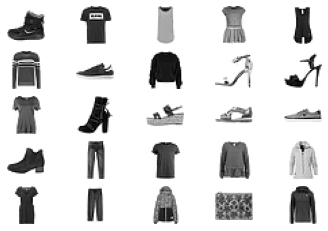

In [ ]:
from matplotlib import pyplot
for i in range(25):
  
  pyplot.subplot(5, 5, 1 + i)
  
  pyplot.axis('off')
  
  pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
 
from IPython import display

In [ ]:
(trn_imag, trn_labl), (_, _) = fashion_mnist.load_data()

In [ ]:
trn_imag = trn_imag.reshape(trn_imag.shape[0], 28, 28, 1).astype('float32')
trn_imag = (trn_imag - 127.5) / 127.5  

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
trn_data = tf.data.Dataset.from_tensor_slices(trn_imag).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def genG_model():
    modelG = tf.keras.Sequential()
    modelG.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
    modelG.add(layers.Reshape((7, 7, 256)))
    assert modelG.output_shape == (None, 7, 7, 256)  
    modelG.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 7, 7, 128)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
   
    modelG.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 14, 14, 64)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
    
    
    modelG.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert modelG.output_shape == (None, 28, 28, 1)
 
    return modelG

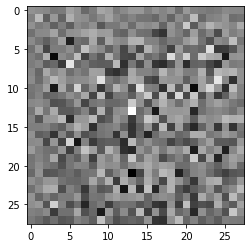

In [ ]:
genG = genG_model()
 
noise = tf.random.normal([1, 100]) 
generated_image = genG(noise, training=False)
 
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    modelD = tf.keras.Sequential()
    
    modelD.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) 
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) 
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Flatten()) 
    modelD.add(layers.Dense(1, activation='sigmoid'))

    return modelD

In [ ]:
discriM = make_discriminator_model()
decision = discriM(generated_image)
print (decision)

tf.Tensor([[0.5001713]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriM_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:
def genG_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
genG_optimizer = tf.keras.optimizers.Adam(1e-4)
discriM_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(genG_optimizer=genG_optimizer,
                                 discriM_optimizer=discriM_optimizer,
                                 genG=genG,
                                 discriM=discriM)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def trn_img(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = genG(noise, training=True)

      real_output = discriM(images, training=True)
      fake_output = discriM(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, genG.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, discriM.trainable_variables)

    genG_optimizer.apply_gradients(zip(grad_genG, genG.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, discriM.trainable_variables))

In [ ]:
def train(dataset, epochs):
  i = 0
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img(image_batch)
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(genG,
                             epoch + 1,
                             seed)
 
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      discriM.save('CheckPoint/Dis%d'%i)
      genG.save('CheckPoint/Gen%d'%i)
      i = i+1
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(genG,
                           epochs,
                           seed)

In [ ]:
def sv_img(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)
 
  fig = plt.figure(figsize=(4, 4))
 
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
 
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

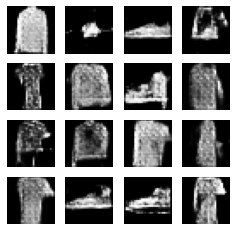

In [ ]:
train(trn_data, EPOCHS)

In [ ]:
from tensorflow.keras.models import load_model

load_gmodel = load_model('CheckPoint/Gen2')
load_dmodel = load_model('CheckPoint/Dis2')
load_gmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
def trn_img_load(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = load_gmodel(noise, training=True)

      real_output = load_dmodel(images, training=True)
      fake_output = load_dmodel(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, load_gmodel.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, load_dmodel.trainable_variables)
    
    genG_optimizer.apply_gradients(zip(grad_genG, load_gmodel.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, load_dmodel.trainable_variables))

In [ ]:
def train_load(dataset, epochs):
  
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img_load(image_batch)
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(load_gmodel, epoch + 1, seed)
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(load_gmodel, epochs, seed)

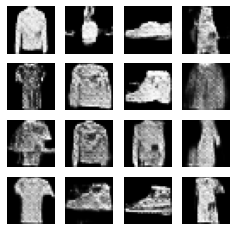

In [ ]:
train_load(trn_data, 50)

The performance is better after using saved weights.

---



In [ ]:
checkpoint_dir = './training_checkpoints'

In [ ]:
genG.save('./training_checkpoints/genG.h5')
discriM.save('./training_checkpoints/discriM.h5')

In [ ]:
genG = tf.keras.models.load_model('./training_checkpoints/genG.h5')
discriM = tf.keras.models.load_model('./training_checkpoints/discriM.h5')

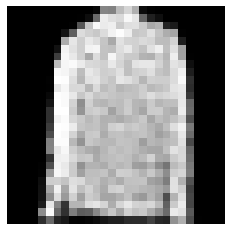

In [ ]:
predictions = genG(seed, training=False)
plt.imshow(predictions[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.savefig('Sample_Image_1.png')
plt.show()

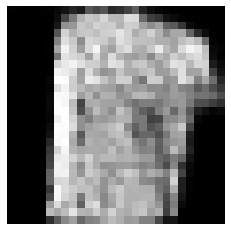

In [ ]:
predictions = genG(seed, training=False)
plt.imshow(predictions[10, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.savefig('Sample_Image_2.png')
plt.show()

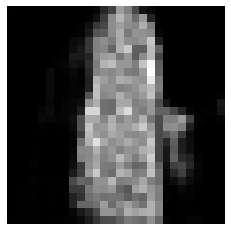

In [ ]:
predictions = genG(seed, training=False)
plt.imshow(predictions[11, :, :, 0] * 127.5 + 127.5, cmap='gray')
plt.axis('off')
plt.savefig('Sample_Image_3.png')
plt.show()

## **PART 2**

In [ ]:
def genG_model():
    modelG = tf.keras.Sequential()
    modelG.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
    modelG.add(layers.Reshape((7, 7, 256)))
    assert modelG.output_shape == (None, 7, 7, 256)  
    modelG.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 7, 7, 128)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
 
    modelG.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert modelG.output_shape == (None, 14, 14, 64)
    modelG.add(layers.BatchNormalization())
    modelG.add(layers.LeakyReLU())
    
    modelG.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert modelG.output_shape == (None, 28, 28, 1)
 
    return modelG

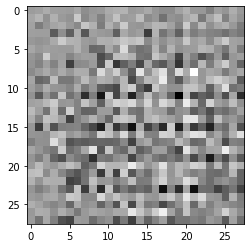

In [ ]:
genG = genG_model()
 
noise = tf.random.normal([1, 100]) 
generated_image = genG(noise, training=False)
 
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    modelD = tf.keras.Sequential()
    
    modelD.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[28, 28, 1])) 
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')) 
    modelD.add(layers.LeakyReLU())
    modelD.add(layers.Dropout(0.3))

    modelD.add(layers.Flatten())  
    modelD.add(layers.Dense(1, activation='sigmoid'))

    return modelD

In [ ]:
discriM = make_discriminator_model()
decision = discriM(generated_image)
print (decision)


tf.Tensor([[0.5001888]], shape=(1, 1), dtype=float32)


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
mse_loss = tf.keras.losses.MeanSquaredError()

In [ ]:
def discriM_loss(real_output, fake_output):
    real_loss = mse_loss(tf.ones_like(real_output), real_output)
    fake_loss = mse_loss(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [ ]:
def genG_loss(fake_output):
    return mse_loss(tf.ones_like(fake_output), fake_output)

In [ ]:
genG_optimizer = tf.keras.optimizers.Adam(1e-4)
discriM_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def trn_img(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = genG(noise, training=True)

      real_output = discriM(images, training=True)
      fake_output = discriM(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, genG.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, discriM.trainable_variables)

    genG_optimizer.apply_gradients(zip(grad_genG, genG.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, discriM.trainable_variables))

In [ ]:
def train(dataset, epochs):
  i=0
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img(image_batch)
 
    
    display.clear_output(wait=True)
    sv_img(genG,
                             epoch + 1,
                             seed)
 
    
    if (epoch + 1) % 15 == 0:
      discriM.save('CheckPoint/Dis%d'%i)
      genG.save('CheckPoint/Gen%d'%i)
      i=i+1
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  
  display.clear_output(wait=True)
  sv_img(genG,
                           epochs,
                           seed)

In [ ]:
def sv_img(model, epoch, test_input):
  
  predictions = model(test_input, training=False)
 
  fig = plt.figure(figsize=(4, 4))
 
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
 
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

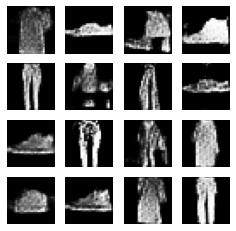

In [ ]:
train(trn_data, EPOCHS)

In [ ]:
from tensorflow.keras.models import load_model

load_gmodel = load_model('CheckPoint/Gen2')
load_dmodel = load_model('CheckPoint/Dis2')
load_gmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_3 (Batc  (None, 12544)            50176     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 7, 7, 128)        819200    
 ranspose)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)       

In [ ]:
def trn_img_load(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = load_gmodel(noise, training=True)

      real_output = load_dmodel(images, training=True)
      fake_output = load_dmodel(generated_images, training=True)

      gen_loss = genG_loss(fake_output)
      disc_loss = discriM_loss(real_output, fake_output)

    grad_genG = gen_tape.gradient(gen_loss, load_gmodel.trainable_variables)
    grad_discriM = disc_tape.gradient(disc_loss, load_dmodel.trainable_variables)
    
    genG_optimizer.apply_gradients(zip(grad_genG, load_gmodel.trainable_variables))
    discriM_optimizer.apply_gradients(zip(grad_discriM, load_dmodel.trainable_variables))

In [ ]:
def train_load(dataset, epochs):
  i = 0
  for epoch in range(epochs):
    start = time.time()
 
    for image_batch in dataset:
      trn_img_load(image_batch)
 
    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    sv_img(load_gmodel, epoch + 1, seed)
 
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
 
  # Generate after the final epoch
  display.clear_output(wait=True)
  sv_img(load_gmodel, epochs, seed)

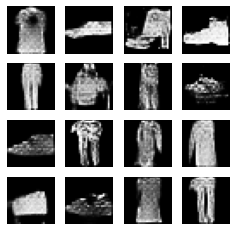

In [ ]:
train_load(trn_data, 50) # better performance with the weights again.